In [56]:
from keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, RandomFlip, RandomRotation, RandomZoom, RandomBrightness
from keras import Sequential
from keras import Model
from keras import models
from keras import metrics
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.utils import array_to_img
import random
import os

**TODO: Prendre le dataset PASTIS https://zenodo.org/record/5012942#.Y_ovYHbMJPY qui contient des series temporelles d'images.(29GB zip :/ )**

DATASER DISPONIBLES POUR LES SERIES TEMPORELLES ( issus du listing ici https://github.com/chrieke/awesome-satellite-imagery-datasets):
- https://github.com/VSainteuf/pastis-benchmark -> dataset agriculture
- https://spacenet.ai/sn7-challenge/ -> dataset de photos de building en construction 

On va prendre x = serie temporelle d'image et entrainer le gan: 
- generateur : a générer des ensembles d'images (donc serie temporelle)
- discriminant : a detecter les mauvaises series temporelles texte en gras

Ce notebook implémente l'augmentation de données d'images satellitaires, en utilisant les méthodes explicitées dans la publication scientifique ***Image Augmentation for Satellite Images*** de Oluwadara Adedeji, Peter Owoade, Opeyemi Ajayi, Olayiwola Arowolo.

Le dataset utilisé est EuroSAT, provenant de http://madm.dfki.de/files/sentinel/EuroSAT.zip. Celui-ci contient 27000 images satellitaires représentant plusieurs types d'environnement  (Végétation, Foret, Résidences, Lacs..) de taille 64*64.

Nous avons décidé de nous concentrer uniquement sur les images RGB afin de réduire la durée d'entraînement nécessaire, d'ou l'utilisation de ce dataset.

Afin d'évaluer l'impact de l'augmentation de données sur les performances d'un modèle, nous allons utiliser le modèle ResNET qui est une référence dans la classification d'image, en l'entraînant avec et sans augmentation de données, puis nous comparerons les performances obtenues.

Pour augmenter les données, nous utiliserons le modèle de GAN DCGAN. Ce GAN utilise des couches de convolution, ce qui améliore la stabilité du modèle lors de l'entraînement.

Nous augmenterons également les données avec des transformations géométriques simples telles que:
*   rotation verticale/horizontale/aléatoire
*   rognage

In [2]:
data_dir = '/content/data'
if not os.path.exists(data_dir):
  os.mkdir( data_dir)

!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O /content/data/data.zip
!unzip /content/data/data.zip -d /content/data 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/data/2750/SeaLake/SeaLake_2206.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_1313.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_263.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_967.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_515.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_1465.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_1817.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_2902.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_2570.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_1004.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_174.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_2111.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_2388.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_1948.jpg  
  inflating: /content/data/2750/SeaLake/SeaLake_838.jpg  
  inflating: /content/data/2750/SeaLake/Se

In [3]:
cpt_file = 0

for root, dirs, files in os.walk(data_dir):
  for file in filter(lambda f: f.endswith('.jpg'), files):
    cpt_file += 1

print(cpt_file)

27000


# Création et normalisation du dataset

In [4]:
"""
Nous créons notre dataset à partir des images EuroSAT, et nous normalisons les valeurs des pixels entre 0 et 1. Cela améliore les performances des GAN.
"""
batch_size = 32
dataset = image_dataset_from_directory(
    os.path.join(data_dir, '2750'), labels='inferred', label_mode='categorical', image_size=(64, 64), batch_size=batch_size
)
x_train = dataset.map(lambda x, y: x / 255.0)
y_train = dataset.map(lambda x, y: y)

Found 27000 files belonging to 10 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Définition du GAN, avec le modèle DCGAN

1.   Définition du générateur
2.   Définition du discriminant

In [5]:
"""
Définition du discriminant selon le modèle DCGAN (simplifié).  
Celui-ci renvoie un score de classification binaire.
"""
discriminator = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [6]:
"""
Définition du générateur selon le modèle DCGAN (simplifié)
"""
latent_dim = 128
generator = Sequential(
    [
        Input(shape=(latent_dim,)),
        Dense(8 * 8 * 128),
        Reshape((8, 8, 128)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [7]:
"""
Définition du modèle en joignant le générateur, et le discriminant
"""
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Recuperation du code depuis l'espace latent
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode en image fake
        generated_images = self.generator(random_latent_vectors)

        # On les ajoute aux vraies images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # On labellise les images (fausses, vraies)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # On ajoute du bruit random aux labels(important)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Recuperation du code depuis l'espace latent
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # On labellise les images (toutes vraies)
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrain le generateur (et PAS le discriminant)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update des metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
"""
Chargement du modele qu'on avait commencé à entrainer (20 epochs)
"""
!unzip gan_discrimnator.zip
!unzip gan_generator.zip

generator = models.load_model('/content/content/gan_generator')
discriminator = models.load_model('/content/content/gan_discrimnator')

Archive:  gan_discrimnator.zip
   creating: content/gan_discrimnator/
 extracting: content/gan_discrimnator/fingerprint.pb  
   creating: content/gan_discrimnator/assets/
  inflating: content/gan_discrimnator/saved_model.pb  
   creating: content/gan_discrimnator/variables/
  inflating: content/gan_discrimnator/variables/variables.data-00000-of-00001  
  inflating: content/gan_discrimnator/variables/variables.index  
  inflating: content/gan_discrimnator/keras_metadata.pb  
Archive:  gan_generator.zip
   creating: content/gan_generator/
 extracting: content/gan_generator/fingerprint.pb  
   creating: content/gan_generator/assets/
  inflating: content/gan_generator/saved_model.pb  
   creating: content/gan_generator/variables/
  inflating: content/gan_generator/variables/variables.data-00000-of-00001  
  inflating: content/gan_generator/variables/variables.index  
  inflating: content/gan_generator/keras_metadata.pb  


# Entraînement du GAN

In [ ]:
epochs = 10  # Test uniquement, Pour obtenir des résultats satisfaisants il faut ~ 200-300 epochs...

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=Adam(learning_rate=0.0001),
    g_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy(),
)


In [66]:
"""
Entrainement et Enregistrement des poids du modele pour pas devoir le re-entrainer à chaque fois, vu la durée de l'entrainement

Relancer cette cellule pour reprendre l'entrainement. On garde une trace de nb d'epochs depuis le début, dans n_trained_epochs
"""

epochs = 50

history = gan.fit(
    x_train, epochs=epochs
)

n_trained_epochs = len(history.history['d_loss'])

gan.generator.save('/content/gan_generator')
gan.discriminator.save('/content/gan_discrimnator')
!zip -r /content/gan_generator.zip /content/gan_generator
!zip -r /content/gan_discrimnator.zip /content/gan_discrimnator

Epoch 1/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.6982 - g_loss: 0.8271
Epoch 2/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.6959 - g_loss: 0.8027
Epoch 3/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.7069 - g_loss: 0.7945
Epoch 4/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.6976 - g_loss: 0.7958
Epoch 5/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.7087 - g_loss: 0.8258
Epoch 6/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.6903 - g_loss: 0.8277
Epoch 7/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.7025 - g_loss: 0.8067
Epoch 8/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.6926 - g_loss: 0.8147
Epoch 9/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.6993 - g_loss: 0.7869
Epoch 10/50
844/844 [==============================] - 22s 26ms/step - d_loss: 0.7

updating: content/gan_generator/ (stored 0%)
updating: content/gan_generator/fingerprint.pb (stored 0%)
updating: content/gan_generator/assets/ (stored 0%)
updating: content/gan_generator/saved_model.pb (deflated 90%)
updating: content/gan_generator/variables/ (stored 0%)
updating: content/gan_generator/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/gan_generator/variables/variables.index (deflated 54%)
updating: content/gan_generator/keras_metadata.pb (deflated 92%)
updating: content/gan_discrimnator/ (stored 0%)
updating: content/gan_discrimnator/fingerprint.pb (stored 0%)
updating: content/gan_discrimnator/assets/ (stored 0%)
updating: content/gan_discrimnator/saved_model.pb (deflated 89%)
updating: content/gan_discrimnator/variables/ (stored 0%)
updating: content/gan_discrimnator/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/gan_discrimnator/variables/variables.index (deflated 51%)
updating: content/gan_discrimnator/keras_metadata.

# Affichage de quelques images crées par le GAN après son entraînement

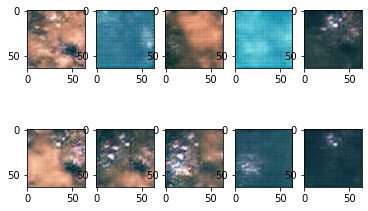

In [67]:
from math import ceil
import matplotlib.pyplot as plt 
"""
Affichage de quelques images crées par le GAN après son entraînement
"""
n_images = 10

cols = 5
rows = ceil( n_images/cols)

fig, axs = plt.subplots( rows, cols)

for row in range(rows):
  for col in range(cols):
      # Creation de points à partir de l'espace latent
      random_latent_vector = tf.random.normal(shape=(1, latent_dim))
      # Creation de l'image en décodant le vecteur 
      generated = gan.generator(random_latent_vector)
      # On enlève la normalisation que nous avons effectué précédemment
      generated *= 255
      # Transformation en object numpy
      generated = generated.numpy().squeeze()
      generated = array_to_img(generated)
      # Affichage
      axs[row][col].imshow( generated)

# Augmentation géométriques de données 

Nous augmentons les données en effectuant des modifications géométriques simples:
*   Rotations horizontales
*   Rotations verticales
*   Rotations aléatoires
Une modification est sélectionnée au hasard parmi les 3, pour chaque image dans le dataset.

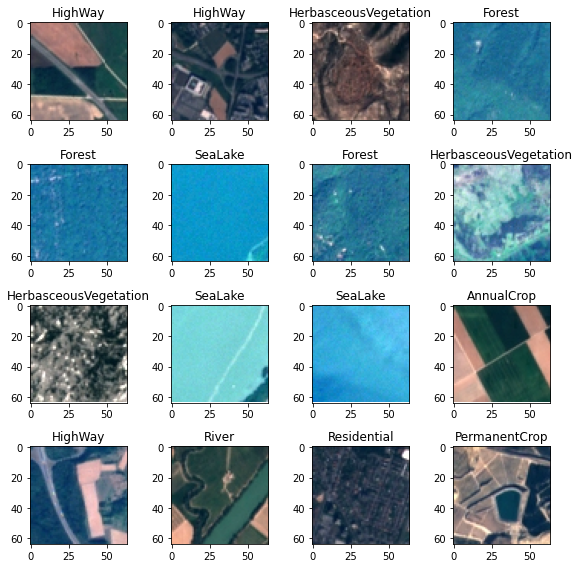

In [68]:
import numpy as np

def get_class_name(y):
  names = ['AnnualCrop','Forest','HerbasceousVegetation','HighWay','Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
  idx = np.where(y == 1)
  return names[idx[0][0]]
  
# pour chaque image on effectuera une transformation aléatoire parmi celles-ci
transformations = [ 
      RandomFlip("horizontal"),
      RandomFlip("vertical"),
      RandomRotation(0.4, fill_mode='reflect'),
      RandomZoom( .5, .2),
      RandomBrightness( factor=0.9)
]

x_train_augmented = []
y_train_augmented = []

# nb_data_to_generate = int(0.1 * cpt_file)
nb_data_to_generate = 64
nb_need_iters = int(nb_data_to_generate/batch_size)

for i in range(nb_need_iters):
  batch_images, batch_y = next(iter(dataset))
  for img, y in zip(batch_images, batch_y):
    transfo = random.choice( transformations)
    x_train_augmented.append( transfo(img))
    y_train_augmented.append( y)
    

dataset_rotated = tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(x_train_augmented),
    tf.convert_to_tensor(y_train_augmented))
)

# on affiche quelques
batch_images, batch_y = next(iter(dataset))
fig, axes = plt.subplots(4,4, figsize=(8,8))
for row in range(4):
  for col in range(4):
    axes[row][col].imshow( array_to_img(batch_images[row*4 + col]))
    axes[row][col].set_title( get_class_name( batch_y[row*4 + col]))
plt.tight_layout()
plt.show()

In [ ]:
print( next(iter(x_train)).shape)

(32, 64, 64, 3)
